In [204]:
import numpy as np
import matplotlib.pyplot as plt
print_figs = True


plt.rcParams.update({
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "lines.linewidth": 3,
})

rng = np.random.default_rng(25)


### 1) Sampling from a hierarchical GMM

In [215]:
# Dimensions / sizes
N = 400      # number of observations
K = 4        # number of clusters
d = 2        # data dimension (2D so we can plot)

# Priors
alpha = np.ones(K) * 10.0          # Dirichlet prior on mixture weights
m0 = np.zeros(d)                  # prior mean for cluster means
Sigma0 = np.eye(d) * 5.0          # prior covariance for cluster means

# Likelihood covariance (within-cluster noise)
Sigma = np.eye(d) * 0.4


In [216]:
# Global latents

# Mixture weights
pi = rng.dirichlet(alpha)   # shape (K,)

# Cluster means
mus = rng.multivariate_normal(mean=m0, cov=Sigma0, size=K)  # shape (K, d)

pi, mus


(array([0.15922732, 0.26470938, 0.25258647, 0.32347683]),
 array([[-1.5343818 ,  0.95759897],
        [-1.80058061,  1.25128368],
        [-0.70245045,  2.00249496],
        [-5.23269304,  0.45871945]]))

In [217]:
# Local latents

# Cluster assignments
z = rng.choice(K, size=N, p=pi)     # shape (N,)

# Observations
x = np.empty((N, d))
for n in range(N):
    x[n] = rng.multivariate_normal(mean=mus[z[n]], cov=Sigma)



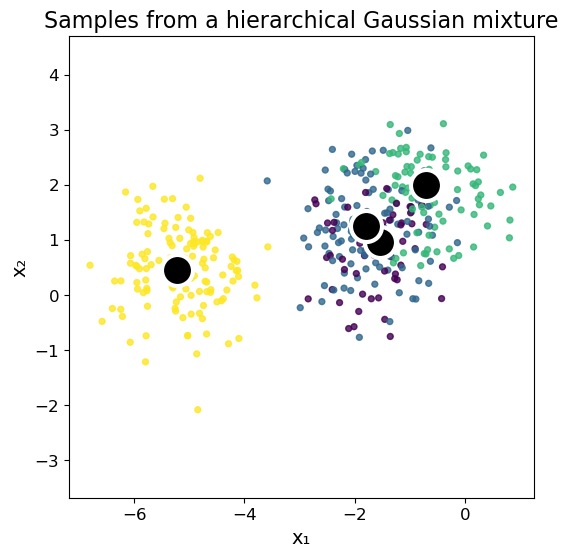

In [218]:
#plot

plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], c=z, s=18, alpha=0.8)

plt.scatter(
    mus[:, 0], mus[:, 1],
    s=500,
    marker="o",
    c="black",
    edgecolors="white",
    linewidths=3,
    zorder=10
)

plt.title(
    "Samples from a hierarchical Gaussian mixture",
    fontsize=16
)
plt.xlabel("x₁", fontsize=14)
plt.ylabel("x₂", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.axis("equal")

if print_figs:
    plt.savefig("../img/week3_hierarchical_GMM.pdf", format="pdf", bbox_inches="tight")

### 2) Bayesian linear regression

In [219]:
# Setup, define the model and sample latents

# Problem size
N = 80          # number of data points
d = 1           # keep d=1 for an easy plot; change to >1 if you like

# Prior on weights: w ~ N(m0, Sigma0)
m0 = np.zeros(d)
Sigma0 = np.eye(d) * 1.0

# Observation noise
sigma = 0.3     # std dev

# Sample latent weights
w = rng.multivariate_normal(m0, Sigma0)   # shape (d,)
w


array([-0.12041957])

In [220]:
# Generate data

# # Input matrix X
x = rng.uniform(-2, 2, size=N)
X = x.reshape(-1, 1)   # N x d

# Generate y = Xw + noise
y = (X @ w).ravel() + rng.normal(0, sigma, size=N)


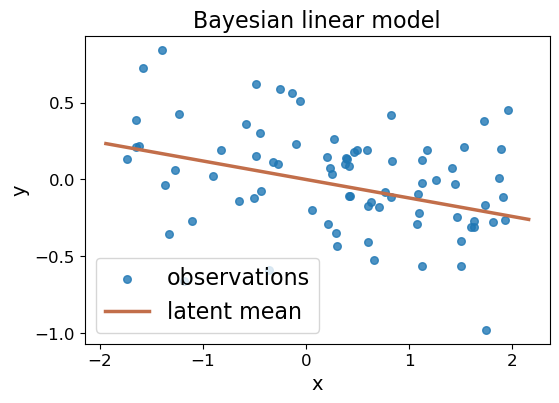

In [221]:
# Grid for plotting the true function
xg = np.linspace(x.min() - 0.2, x.max() + 0.2, 200)
Xg = xg.reshape(-1, 1)
yg_true = (Xg @ w).ravel()

plt.figure(figsize=(6, 4))
plt.scatter(x, y, s=30, alpha=0.8, label="observations")
plt.plot(
    xg, yg_true,
    linewidth=2.5,
    color="#C26E4A",
    label="latent mean"
)
plt.title("Bayesian linear model", fontsize=16)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

if print_figs:
    plt.savefig("../img/week3_bayesian_linear_reg.pdf", format="pdf", bbox_inches="tight")


### 3) Nonlinear state space model

In [222]:
# Define the model and choose f and h

T = 400

# Noise scales (1D for clarity)
q = 0.25   # process noise std
r = 0.45   # observation noise std

# Nonlinear transition and observation functions
def f(z):
    # mildly nonlinear and stable dynamics
    return 0.7 * z + 0.5 * np.sin(z)

def h(z):
    # nonlinear observation
    return z**2 / 5.0


In [223]:
# Simulate latent and observed trajectories

z = np.zeros(T)
y = np.zeros(T)  # noiseless output y_t = h(z_t)
x = np.zeros(T)  # observations

# Prior for z1
z[0] = rng.normal(0.0, 1.0)

for t in range(1, T):
    z[t] = f(z[t-1]) + rng.normal(0.0, q)

y = h(z)
x = y + rng.normal(0.0, r, size=T)**2


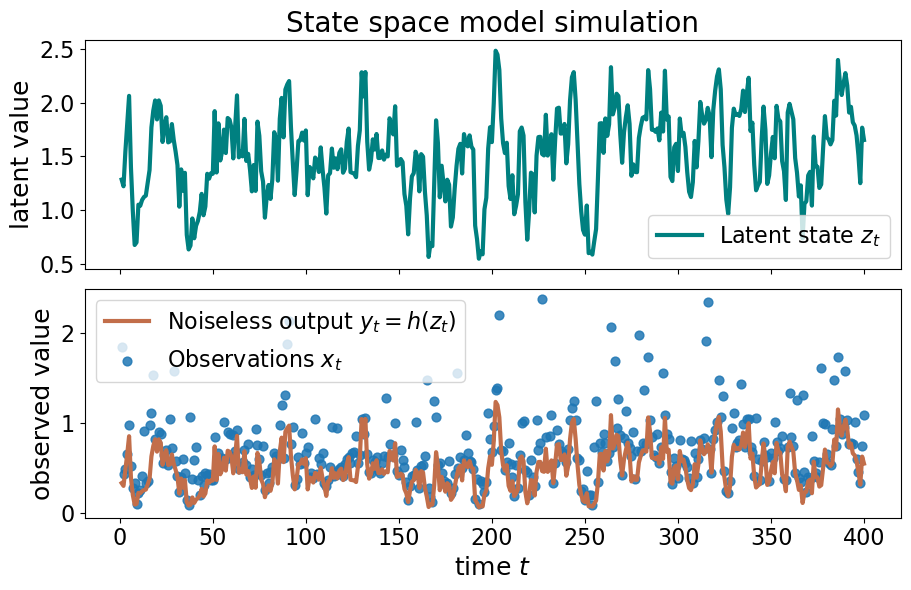

In [224]:
#plot everything

t = np.arange(1, T + 1)

fig, axes = plt.subplots(
    2, 1,
    figsize=(9, 6),
    sharex=True
)

# Top: latent trajectory
axes[0].plot(
    t, z,
    color="teal",
    label="Latent state $z_t$"
)
axes[0].set_ylabel("latent value")
axes[0].set_title("State space model simulation")
axes[0].legend()
axes[0].tick_params(axis="both")

# Bottom: noiseless output and observations
axes[1].plot(
    t, y,
    color="#C26E4A",
    label="Noiseless output $y_t = h(z_t)$"
)
axes[1].scatter(
    t, x,
    s=40,        # slightly larger points for print
    alpha=0.85,
    label="Observations $x_t$"
)
axes[1].set_xlabel("time $t$")
axes[1].set_ylabel("observed value")
axes[1].legend()
axes[1].tick_params(axis="both")

plt.tight_layout()



if print_figs:
    plt.savefig("../img/week3_SSM.pdf", format="pdf", bbox_inches="tight")



### 4) Metropolis Hastings

In [225]:
# Define target: 2D Gaussian mixture (log density)

N_steps = 10000
# Mixture parameters
weights = np.array([0.55, 0.45])
mus = np.array([[-2.0, -1.0],
                [ 2.2,  1.7]])
Sigmas = np.array([
    [[1.0,  0.9],
     [0.9,  1.0]],
    [[0.9, -0.8],
     [-0.8, 0.9]]
])

inv_Sigmas = np.linalg.inv(Sigmas)
logdets = np.linalg.slogdet(Sigmas)[1]

def log_mvnorm(x, mu, inv_Sigma, logdet):
    d = x.shape[0]
    dx = x - mu
    quad = dx @ inv_Sigma @ dx
    return -0.5 * (d*np.log(2*np.pi) + logdet + quad)

def log_target(x):
    # log p(x) for mixture via stable log-sum-exp
    comps = np.array([
        np.log(weights[k]) + log_mvnorm(x, mus[k], inv_Sigmas[k], logdets[k])
        for k in range(len(weights))
    ])
    m = comps.max()
    return m + np.log(np.exp(comps - m).sum())


In [226]:
# Metropolis–Hastings sampler (Gaussian random-walk proposal)

burn_in = 1
n_steps = N_steps + burn_in
proposal_std = 0.9  # tune: larger => lower acceptance, smaller => slower mixing

samples = np.zeros((n_steps, 2))
x = np.array([0.0, 0.0])          # initial state
logp_x = log_target(x)
accepted = 0

for t in range(n_steps):
    # single-Gaussian proposal: q(x'|x) = N(x, s^2 I)
    x_prop = x + rng.normal(0.0, proposal_std, size=2)
    logp_prop = log_target(x_prop)

    # symmetric proposal => MH ratio is just target ratio
    log_alpha = logp_prop - logp_x
    if np.log(rng.uniform()) < min(0.0, log_alpha):
        x, logp_x = x_prop, logp_prop
        accepted += 1

    samples[t] = x

acc_rate = accepted / n_steps
acc_rate


0.3608639136086391

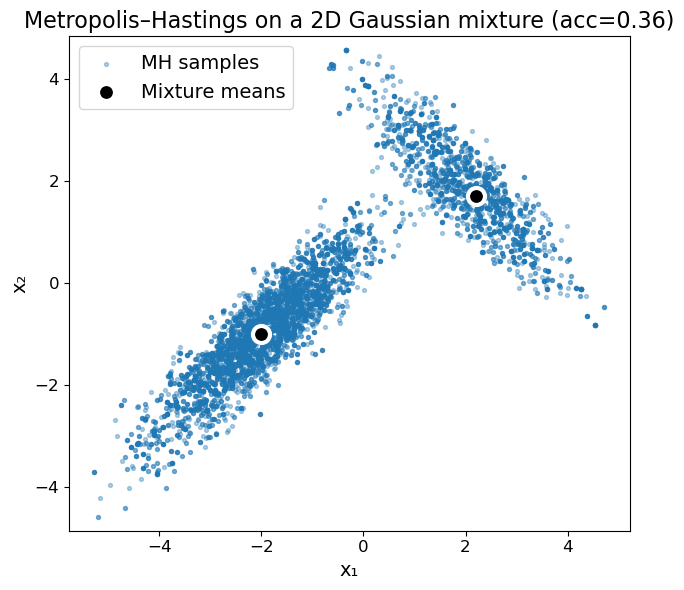

In [241]:
#plot

post = samples[burn_in:]

plt.figure(figsize=(6.5, 6.0))
plt.scatter(post[:, 0], post[:, 1], s=8, alpha=0.35, label="MH samples")
plt.scatter(
    mus[:, 0], mus[:, 1],
    s=150, marker="o", c="black",
    edgecolors="white", linewidths=3, zorder=10,
    label="Mixture means"
)

plt.title(f"Metropolis–Hastings on a 2D Gaussian mixture (acc={acc_rate:.2f})", fontsize=16)
plt.xlabel("x₁", fontsize=14)
plt.ylabel("x₂", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, markerscale=1)
plt.axis("equal")
plt.tight_layout()

if print_figs:
    plt.savefig("../img/week3_MH_GMM.pdf", format="pdf", bbox_inches="tight")


In [228]:
### 6) Gibbs vs Metropolis Hastings

In [229]:
# Define correlated Gaussian

mu = np.array([0.0, 0.0])
rho = 0.99
Sigma = np.array([[1.0, rho],
                  [rho, 1.0]])

inv_Sigma = np.linalg.inv(Sigma)
logdet = np.linalg.slogdet(Sigma)[1]

def log_target(x):
    dx = x - mu
    quad = dx @ inv_Sigma @ dx
    d = 2
    return -0.5 * (d*np.log(2*np.pi) + logdet + quad)



In [230]:
# MH with random walk

def mh_rw(n_steps, proposal_std, rng, x0=None):
    x = np.array([3.0, -3.0]) if x0 is None else np.array(x0, dtype=float)
    xs = np.zeros((n_steps, 2))
    logp = log_target(x)
    accepted = 0

    for t in range(n_steps):
        x_prop = x + rng.normal(0.0, proposal_std, size=2)  # N(x, s^2 I)
        logp_prop = log_target(x_prop)

        log_alpha = logp_prop - logp  # symmetric proposal
        if np.log(rng.uniform()) < min(0.0, log_alpha):
            x, logp = x_prop, logp_prop
            accepted += 1

        xs[t] = x

    return xs, accepted / n_steps

n_steps = 20000
burn_in = 2000
proposal_std = 0.8  # tune: lower -> higher acc but slower exploration; higher -> lower acc

mh_samples, mh_acc = mh_rw(n_steps=n_steps, proposal_std=proposal_std, rng=rng)
mh_post = mh_samples[burn_in:]
mh_acc


0.1444

In [231]:
# Gibbs

def gibbs_gaussian(n_steps, rng, x0=None):
    x = np.array([3.0, -3.0]) if x0 is None else np.array(x0, dtype=float)
    xs = np.zeros((n_steps, 2))

    s11, s12 = Sigma[0, 0], Sigma[0, 1]
    s22 = Sigma[1, 1]

    # Conditional variances (constants for Gaussian)
    var_x1_given_x2 = s11 - (s12**2) / s22
    var_x2_given_x1 = s22 - (s12**2) / s11

    for t in range(n_steps):
        # x1 | x2
        mean1 = mu[0] + (s12 / s22) * (x[1] - mu[1])
        x[0] = rng.normal(mean1, np.sqrt(var_x1_given_x2))

        # x2 | x1
        mean2 = mu[1] + (s12 / s11) * (x[0] - mu[0])
        x[1] = rng.normal(mean2, np.sqrt(var_x2_given_x1))

        xs[t] = x

    return xs

gibbs_samples = gibbs_gaussian(n_steps=n_steps, rng=rng)
gibbs_post = gibbs_samples[burn_in:]


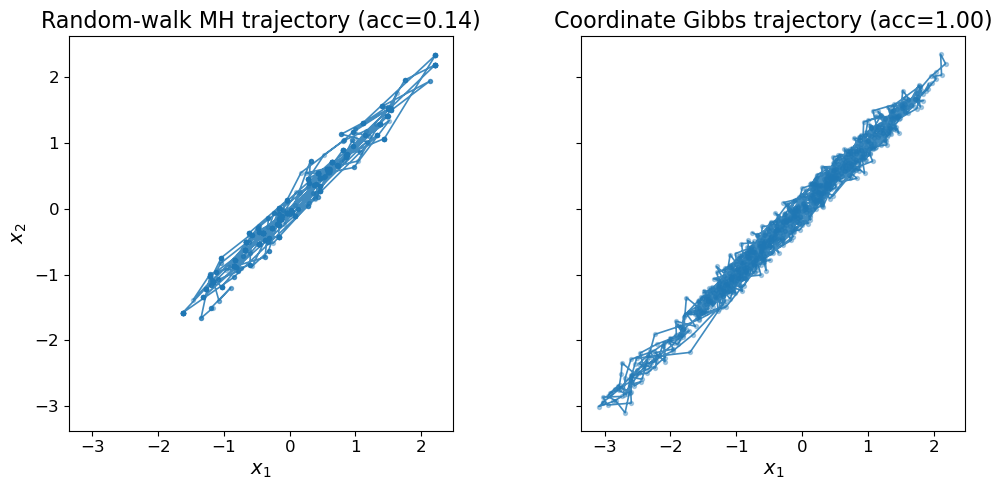

In [243]:
# Plot

# Plot only the first part of post-burn-in to keep the trajectory readable
L = 1000
mh_traj = mh_post[:L]
gb_traj = gibbs_post[:L]

fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharex=True, sharey=True)

axes[0].plot(mh_traj[:, 0], mh_traj[:, 1], linewidth=1.2, alpha=0.85)
axes[0].scatter(mh_traj[:, 0], mh_traj[:, 1], s=8, alpha=0.35)
axes[0].set_title(f"Random-walk MH trajectory (acc={mh_acc:.2f})", fontsize=16)
axes[0].set_xlabel("$x_1$", fontsize=14)
axes[0].set_ylabel("$x_2$", fontsize=14)
axes[0].tick_params(labelsize=12)

axes[1].plot(gb_traj[:, 0], gb_traj[:, 1], linewidth=1.2, alpha=0.85)
axes[1].scatter(gb_traj[:, 0], gb_traj[:, 1], s=8, alpha=0.35)
axes[1].set_title("Coordinate Gibbs trajectory (acc=1.00)", fontsize=16)
axes[1].set_xlabel("$x_1$", fontsize=14)
axes[1].tick_params(labelsize=12)


# Make axes comparable and visually stable
for ax in axes:
    ax.set_aspect("equal", adjustable="box")

plt.tight_layout()

if print_figs:
    plt.savefig("../img/week3_Gibbs_vs_MH.pdf", format="pdf", bbox_inches="tight")
